In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
area_list = [str(i) for i in range(81)]
area_one_length = 9

In [3]:
from collections import namedtuple
ARGS_FOR_LIST = namedtuple('FOR_LIST', ('dir', 'ratio', 'seed', 'csv'))

def get_for_list():
    dir_list = ['p10000', 'p20000', 'p30000']
    ratio_list = ['r4', 'r5', 'r6']
    seed_list = ['s'+str(123 + i) for i in range(1)]
    csv_list = ['census', 'mobile', 'od']

    return ARGS_FOR_LIST(dir_list, ratio_list, seed_list, csv_list)

In [4]:
def get_read_path(name):
    path = '/Users/kessapassa/OneDrive/research_log/20190331/' + name + '/'
    return path

def get_file_name(args):
    return args.dir + args.ratio + args.seed + '_' + args.csv + '.csv'

def get_full_path(name, args):
    return get_read_path(name) + get_file_name(args)

In [5]:
def get_full_area_path(name, args, area):
    return get_read_path(name) + args.dir + args.ratio + args.seed + '_' + args.csv + area + '.csv'

In [6]:
def for_default_init(func, array):
    for_list = get_for_list()
    
    for _dir in for_list.dir:
        array[_dir] = {}
        
        for _ratio in for_list.ratio:
            array[_dir][_ratio] = {}
            
            for _seed in for_list.seed:
                array[_dir][_ratio][_seed] = {}
                
                for _csv in for_list.csv:
                    array[_dir][_ratio][_seed][_csv] = {}
                    args = ARGS_FOR_LIST(_dir, _ratio, _seed, _csv)
                    func(args, array)

In [7]:
def create_base_dataframe():
    df = pd.DataFrame(columns=(['{0:02d}'.format(i*10) for i in range(area_one_length)]))
    return df

In [8]:
create_base_dataframe()

,00,10,20,30,40,50,60,70,80


In [9]:
# エリア番号を線形的な数から、iとjで回した数のようにする
def convert_area_to_contour(base, read):
    for r in np.asanyarray(read):
        area_id = int(r[0])
        row = str(area_id // area_one_length)
        col = str(area_id % area_one_length) + '0'
        base.loc[row, col] = r[1]
        
    return base

In [10]:
def area_to_contour(area_id):
    area_id = int(area_id)
    left = str(area_id // area_one_length)
    right = str(area_id % area_one_length) + '0'
    return left+right

In [11]:
base = create_base_dataframe()

csv_array = {}
def main(args, array):
    for _area in area_list:
        df = pd.read_csv(get_full_area_path('next_move_area', args, _area),
                         encoding='Shift_JISx0213')
        df = convert_area_to_contour(base.copy(), df.copy())
    #                 df = df / df.sum().sum()
        df = df.sort_index(ascending=False)
        df.fillna(0, inplace=True)

        _area = area_to_contour(_area)
        array[args.dir][args.ratio][args.seed][args.csv][_area]= df
        
for_default_init(main, csv_array)

In [12]:
def create_contour(df):
    plt.figure(figsize=(9,6))
    sns.heatmap(df, annot=True, fmt='.０f', cmap='RdYlGn_r',
               vmax=df.sum().mean())

In [99]:
people = 'p20000'
ratio = 'r4'
seed = 's123'
csv = 'mobile'

In [100]:
df_area_sum = pd.DataFrame(columns=['area', 'sum'])
for _area in [area_to_contour(i) for i in area_list]:
    df = pd.DataFrame([_area, csv_array[people][ratio][seed][csv][_area].sum().sum()], index=['area', 'sum']).T
    df_area_sum = pd.concat([df_area_sum, df])
df_area_sum.reset_index(drop=True, inplace=True)
df_area_sum = df_area_sum[df_area_sum['sum'] > 0]
df_area_sum = df_area_sum.sort_values(by=['sum'], ascending=False)
df_area_sum.head()

,area,sum
49,540,264
40,440,92
41,450,71
50,550,67
58,640,44


In [101]:
df_area_sum['sum'].sum()

707.0

In [102]:
diff1_array = []
diff2_array = []
target_array = []
od_array = []

for _area in area_list:
    _area = area_to_contour(_area)
    
    target = csv_array[people][ratio][seed][csv][_area].copy()
    od = csv_array[people][ratio][seed]['od'][_area].copy()
    
    if (target.sum().sum() > 0) and (od.sum().sum() > 0):
        diff1 = target / od
        diff2 = od / target
        diff1 = diff1.replace(np.inf,np.nan).fillna(0)
        diff2 = diff2.replace(np.inf,np.nan).fillna(0)
        
        diff1_array.append(diff1.mean().mean())
        diff2_array.append(diff2.mean().mean())
        target_array.append(target.mean().mean())
        od_array.append(od.mean().mean())

#         print(_area)
#         print(diff1.mean().mean())
#         print(diff2.mean().mean())
#         print('\n')

y =          2
-5.631 x + 24.87 x - 0.6617
相関 =  0.7004397710835981


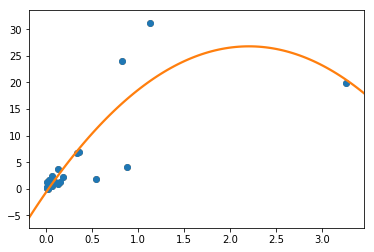

In [103]:
trainX = target_array
trainY = od_array

# plt.figure(figsize=(9,6), dpi=600)
plt.plot(trainX, trainY, 'o')
order=2
sns.regplot(x=trainX, y=trainY, order=order, ci=0)
z = np.polyfit(trainX, trainY, order)
z = np.squeeze(z)
p = np.poly1d(z)
print('y = ', p)
print('相関 = ', np.corrcoef(trainX, trainY)[0,1])
# print('R^2 = ', r2_score(trainX, trainY))

In [104]:
csv_array_2d = {}
def create2d(args, array):
    for _area in area_list:
        df = pd.read_csv(get_full_area_path('next_move_area', args, _area),
                         encoding='Shift_JISx0213')
        _area = area_to_contour(_area)
        array[args.dir][args.ratio][args.seed][args.csv][_area] = df
        
for_default_init(create2d, csv_array_2d)

540
y =            2
-0.01793 x + 9.135 x - 0.5983
相関 =  0.9838769903541777


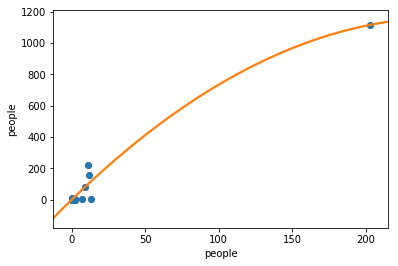

In [105]:
area = df_area_sum.iloc[0, 0]
print(area)

target = csv_array_2d[people][ratio][seed][csv][area].copy()
od = csv_array_2d[people][ratio][seed]['od'][area].copy()

trainX = target['people']
trainY = od['people']

# plt.figure(figsize=(9,6), dpi=600)
plt.plot(trainX, trainY, 'o')
order=2
sns.regplot(x=trainX, y=trainY, order=order, ci=0)
z = np.polyfit(trainX, trainY, order)
z = np.squeeze(z)
p = np.poly1d(z)
print('y = ', p)
print('相関 = ', np.corrcoef(trainX, trainY)[0,1])

440 相関 =  0.8430789699322524
450 相関 =  0.6892920072509272
540 相関 =  0.9838769903541777
550 相関 =  0.890984066184889
640 相関 =  0.7078197293091608


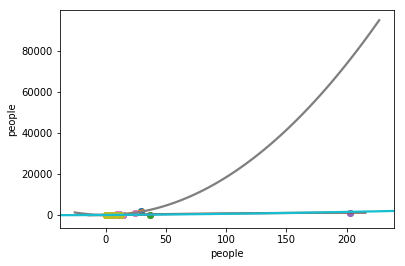

In [106]:
# plt.figure(figsize=(9,6), dpi=600)
# ax = plt.subplot()
# ax.set_xlim([-100, 100])
# ax.set_ylim([-1000, 2000])
import warnings
warnings.filterwarnings('ignore')

for _area in area_list:
    _area = area_to_contour(_area)
    target = csv_array_2d[people][ratio][seed][csv][_area].copy()
    od = csv_array_2d[people][ratio][seed]['od'][_area].copy()

    trainX = target['people']
    trainY = od['people']
#     plt.figure(figsize=(9,6), dpi=600)

    corr = np.corrcoef(trainX, trainY)[0,1]
    if (np.isnan(corr) == False) and (trainX.mean().mean() > 0.5):

        plt.plot(trainX, trainY, 'o')
        order=2
        sns.regplot(x=trainX, y=trainY, order=order, ci=0)
        z = np.polyfit(trainX, trainY, order)
        z = np.squeeze(z)
        p = np.poly1d(z)
#         print('y = ', p)
        print(_area, '相関 = ', corr)
#         plt.savefig('{0}_mobile_include_id.png'.format(_area))

In [107]:
def create_mobile_od_counter(area):
    print(csv_array[people][ratio][seed][csv][area].sum().sum())
    print(csv_array[people][ratio][seed]['od'][area].sum().sum())
    create_contour(csv_array[people][ratio][seed][csv][area])
    create_contour(csv_array[people][ratio][seed]['od'][area])

# コンター図

エリア: 540

264.0
1614.0


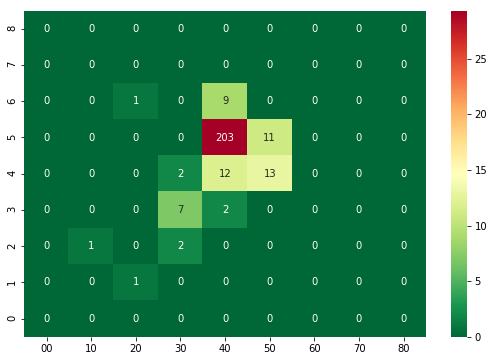

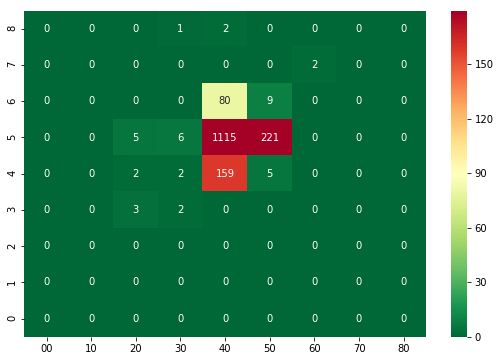

In [120]:
area = df_area_sum.iloc[0, 0]
print('エリア: ' + area + '\n')
create_mobile_od_counter(area)

エリア: 440

92.0
2529.0


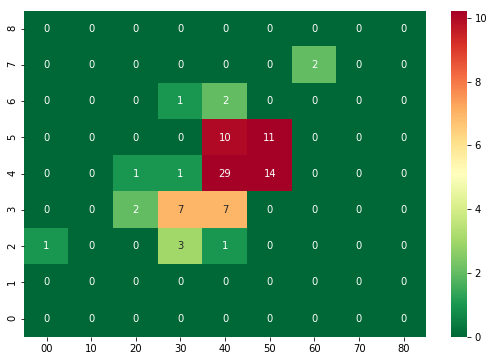

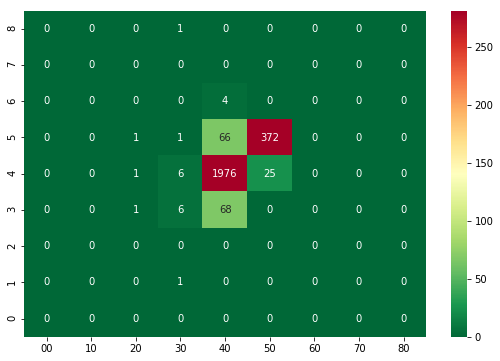

In [121]:
area = df_area_sum.iloc[1, 0]
print('エリア: ' + area + '\n')
create_mobile_od_counter(area)

エリア: 450

71.0
340.0


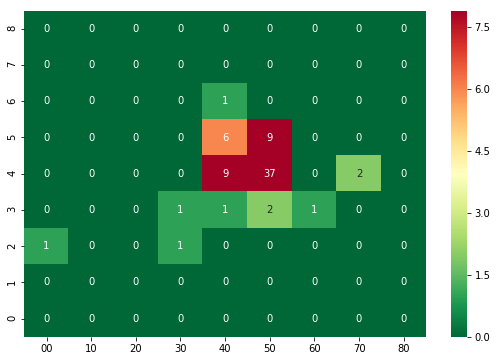

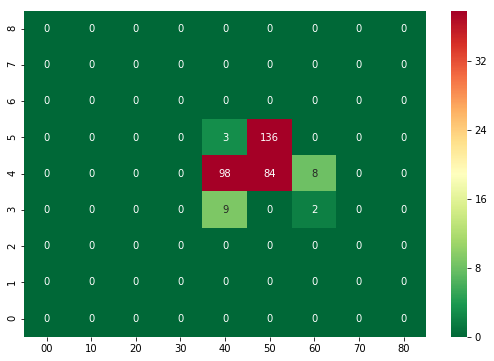

In [122]:
area = df_area_sum.iloc[2, 0]
print('エリア: ' + area + '\n')
create_mobile_od_counter(area)

エリア: 550

67.0
1942.0


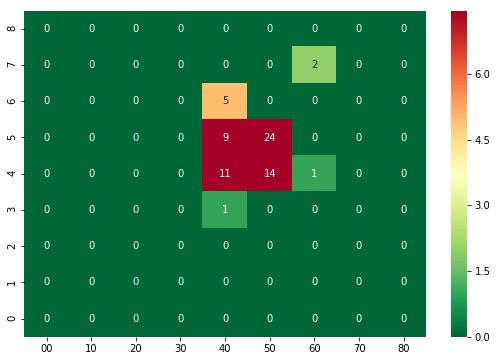

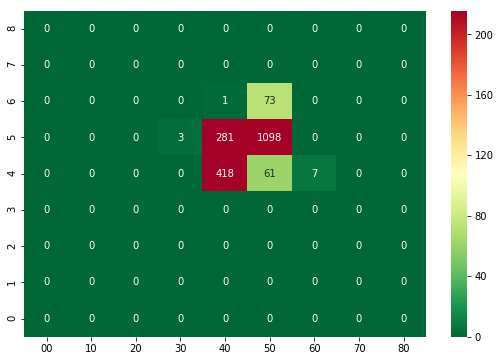

In [123]:
area = df_area_sum.iloc[3, 0]
print('エリア: ' + area + '\n')
create_mobile_od_counter(area)

In [141]:
# def create_contour_diff(df):
#     plt.figure(figsize=(9,6))
#     sns.heatmap(df, annot=True, fmt='.3f', cmap='RdYlGn_r',
#                vmax=df.sum().mean())

In [142]:
# def create_diff_counter(area):
#     taget = csv_array[people][ratio][seed][csv][area].copy()
#     od = csv_array[people][ratio][seed]['od'][area].copy()
    
#     diff_target = target / od
#     diff_od = od / target
    
#     diff_target = diff_target.replace(np.inf,np.nan).fillna(0)
#     diff_od = diff_od.replace(np.inf,np.nan).fillna(0)
    
#     create_contour_diff(diff_target)
#     create_contour_diff(diff_od)

In [146]:
# area = df_area_sum.iloc[0, 0]
# print('エリア: ' + area + '\n')
# create_diff_counter(area)

エリア: 440



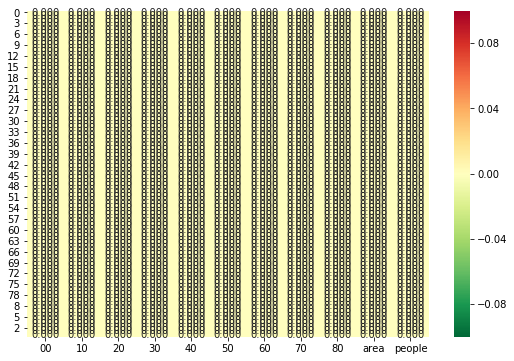

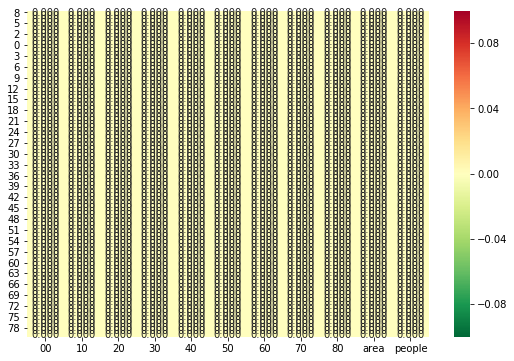

In [144]:
# area = df_area_sum.iloc[1, 0]
# print('エリア: ' + area + '\n')
# create_diff_counter(area)

エリア: 450



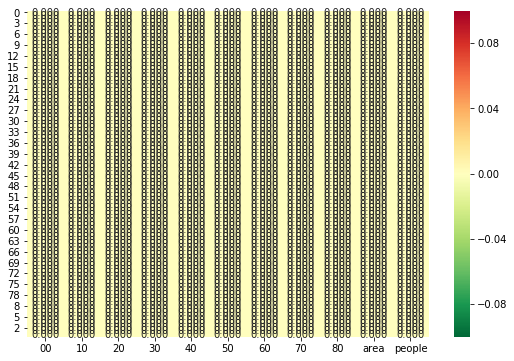

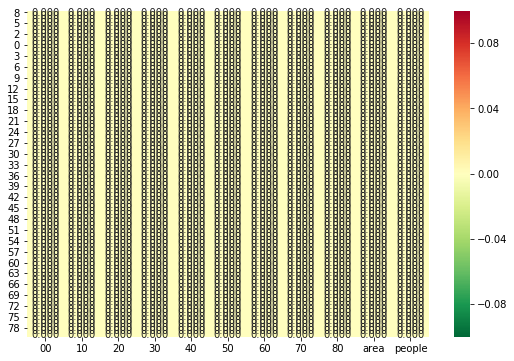

In [145]:
# area = df_area_sum.iloc[2, 0]
# print('エリア: ' + area + '\n')
# create_diff_counter(area)